# Advanced Lane Lines

This is project 4 of the Self-Driving Car Nanodegree, Advanced Lane Lines.

## Camera Calibration

In this section, we calibrate the camera used for the images.

### Object/Image Point Extraction

The first step is to extract object and image points from chessboard images. This is adapted from https://github.com/udacity/CarND-Camera-Calibration/

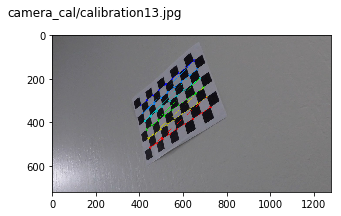

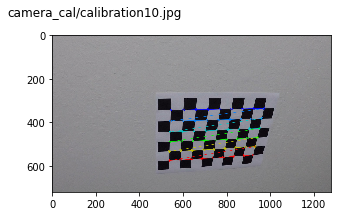

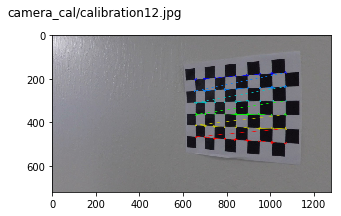

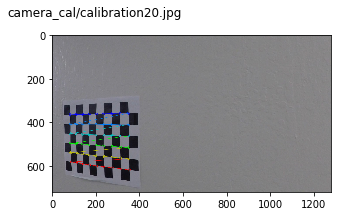

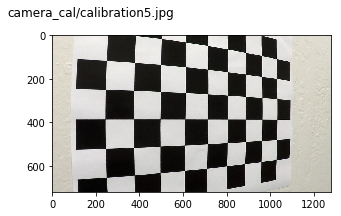

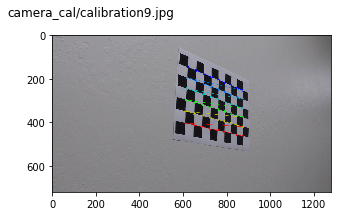

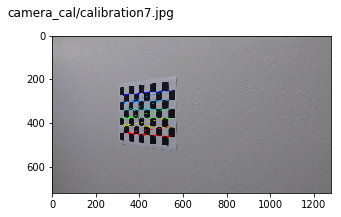

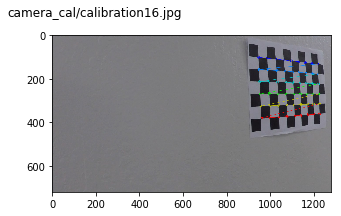

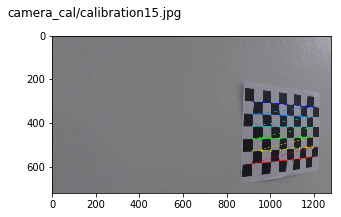

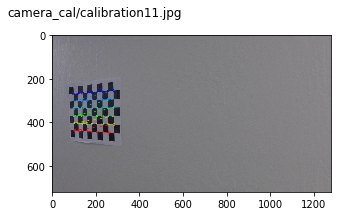

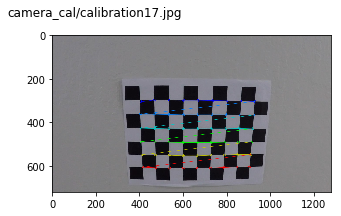

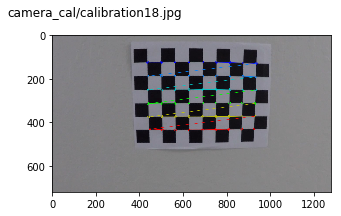

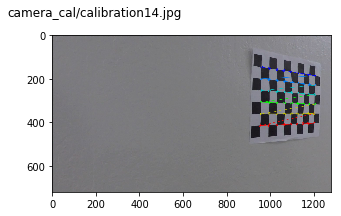

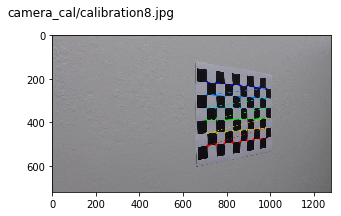

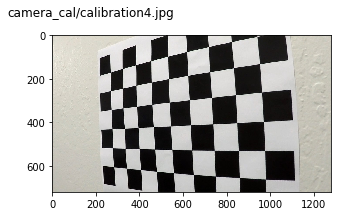

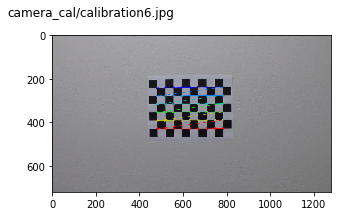

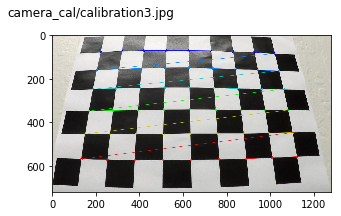

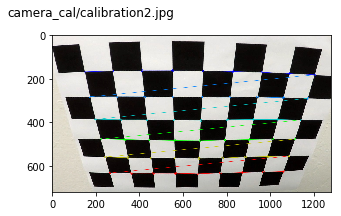

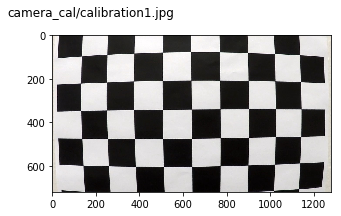

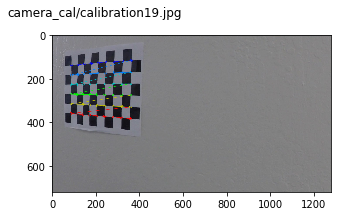

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Array to save the shape of images recorded from the camera
shape = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    shape = img.shape

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
    # Not all images can find the whole chessboard as it's cut off in
    # some of the images
    plt.figure(figsize=(5,5))
    plt.suptitle(fname, x = 0, y = 0.8, horizontalalignment = 'left')
    plt.imshow(img)


### Calibrate Camera

The second step is to run the calibrateCamera function to get the camera matrix and the distortion coefficients. We test the validity of the returned values by undistorting one of the calibration images and one of the test images.

[[  1.15777942e+03   0.00000000e+00   6.67111050e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129068e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.24688833 -0.02372817 -0.00109843  0.00035105 -0.00259134]]


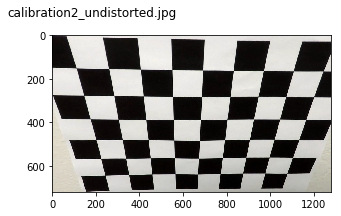

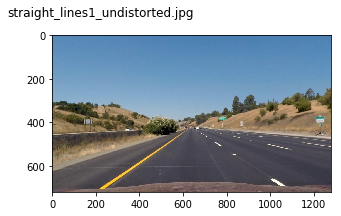

In [2]:
# Get camera matrix and distortion coefficients from object and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (shape[1], shape[0]), None, None)

print(mtx)
print(dist)

fnames = ['camera_cal/calibration2.jpg', 'test_images/straight_lines1.jpg']

# Undistort images, plot them, and write them to the output_images directory
for fname in fnames:
    img = cv2.undistort(mpimg.imread(fname), mtx, dist, None, mtx)
    fname = fname[fname.rindex('/')+1:].replace('.jpg', '_undistorted.jpg', 1)
    plt.figure(figsize=(5,5))
    plt.suptitle(fname, x = 0, y = 0.8, horizontalalignment = 'left')
    _ = plt.imshow(img)
    _ = mpimg.imsave('output_images/' + fname, img, format='jpg')

## Image Pipeline

This section defines the image pipeline. The pipeline defines a series of steps applied to each image, and returns the result of each of those steps for debugging purposes when `debug` is `True`.

In [3]:
# Pick source points by the visible ends of the straight lane lines
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
# Pick destination points at the corners of the transformed image
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

left_fit, right_fit = None, None

# Define pipeline. The `debug` option returns all intermediate images for saving to the
# output_images subdirectory as required by the rubric.
def pipeline(img, s_thresh=(20, 255), sx_thresh=(20, 255), sy_thresh=(20, 255), n_windows=9, margin=100, min_pix = 50, debug=False):
    # Access the global prev_fits
    global left_fit, right_fit
    
    # Undistort using known camera matrix and distortion coefficients
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobelx) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine all three channels
    comb_binary = np.zeros_like(sxbinary)
    comb_binary[(sxbinary + sxbinary + s_binary) > 1] = 1

    # Warp the perspective of the image to get a bird's eye view
    warp_img = cv2.warpPerspective(comb_binary, M, (comb_binary.shape[1], comb_binary.shape[0]))
    
    
    # Get nonzero pixels of warped image
    nonzero = warp_img.nonzero()
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    
    # We'll change this to True when we find a valid lane line, otherwise we'll keep iterating
    success = False
    
    while success == False:

        # Create an output image
        out_img = np.dstack((warp_img, warp_img, warp_img))*255
    
        # Create a list of points to use for polynomial fitting
        left_points = []
        right_points = []

        if ((left_fit == None) and (right_fit == None)):
            # Find the approximate location of the lane lines
            histogram = np.sum(warp_img[int(warp_img.shape[0]/2):,:], axis=0)
    
            # Find left and right peaks in the histogram
            midpoint = np.int(histogram.shape[0]/2)
            left_peak = np.argmax(histogram[:midpoint])
            right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
            # Set initial conditions
            left_x = left_peak
            right_x = right_peak
    
            # Set height of windows
            win_height = np.int(warp_img.shape[0]/n_windows)

            # Iterate through windows, finding lane line
            for i in range(n_windows):
                # Get window boundaries
                win_bottom = warp_img.shape[0] - (i * win_height)
                win_top = win_bottom - win_height
                leftwin_left = left_x - margin
                leftwin_right = left_x + margin
                rightwin_left = right_x - margin
                rightwin_right = right_x + margin
                # Draw window
                cv2.rectangle(out_img,(leftwin_left, win_bottom),(leftwin_right, win_top),(0,255,0), 2)
                cv2.rectangle(out_img,(rightwin_left, win_bottom),(rightwin_right, win_top),(0,255,0), 2)
                # Get all nonzero points in the left and right windows
                left_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom) & (nonzerox >= leftwin_left) & (nonzerox < leftwin_right)).nonzero()[0]
                right_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom) & (nonzerox >= rightwin_left) & (nonzerox < rightwin_right)).nonzero()[0]
                # Append the points to the list of points to which to fit curves
                left_points.append(left_inds)
                right_points.append(right_inds)
                # If there are enough new points, recenter window on the mean X of the windows
                if len(left_inds) > min_pix:
                    left_x = np.int(np.mean(nonzerox[left_inds]))
                if len(right_inds) > min_pix:
                    right_x = np.int(np.mean(nonzerox[right_inds]))

            # Concatenate the arrays of points
            left_points = np.concatenate(left_points)
            right_points = np.concatenate(right_points)

        else:
            # Use points around previously-found curves to keep us on track
            left_points = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_points = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
        # Fit the preliminary polynomial for each lane
        left_fit_p = np.polyfit(nonzeroy[left_points], nonzerox[left_points], 2)
        right_fit_p = np.polyfit(nonzeroy[right_points], nonzerox[right_points], 2)
        # If previously-saved fits exist, average them into the preliminary fits and create weighted average
        if ((left_fit != None) and (right_fit != None)):
            left_fit_p = (left_fit + left_fit_p)/2
            right_fit_p = (right_fit + right_fit_p)/2
        tried_fit = False
        new_fit = True
        while new_fit:
            # Create preliminary arrays of points to plot
            ploty_p = np.linspace(0, out_img.shape[0]-1, out_img.shape[0]).astype(np.int)
            left_fitx_p = (left_fit_p[0]*ploty_p**2 + left_fit_p[1]*ploty_p + left_fit_p[2]).astype(np.int)
            right_fitx_p = (right_fit_p[0]*ploty_p**2 + right_fit_p[1]*ploty_p + right_fit_p[2]).astype(np.int)
            # Filter the points to make sure they fit in the image
            ploty, left_fitx, right_fitx = [], [], []
            for (y, lx, rx) in zip(ploty_p, left_fitx_p, right_fitx_p):
                if ((lx >= 0) and (lx < out_img.shape[1]) and (rx >= 0) and (rx < out_img.shape[1])):
                    ploty.append(y)
                    left_fitx.append(lx)
                    right_fitx.append(rx)
            # Convert into ndarrays for future processing
            ploty, left_fitx, right_fitx = np.asarray(ploty), np.asarray(left_fitx), np.asarray(right_fitx)

            # Get X meters per pixel assuming a lane width of 3.7 meters at bottom of image
            y_eval = np.int(np.max(ploty))
            y_eval_ind = len(ploty) - 1
            lane_width = right_fitx[y_eval_ind] - left_fitx[y_eval_ind]
            mppx = 3.7/(lane_width)
    
            # Calculate offset from center in meters - negative is to the left, positive is to the right
            offset = mppx * (out_img.shape[1]/2 - lane_width/2 - left_fitx_p[y_eval_ind])
        
            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension

            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
            
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
            # Assume we'll exit loops at both levels
            new_fit = False
            success = True

            # If offset is bad - like we're outside the lane - or if the curve radius is too small, try again with
            # because it's a difficult frame. If we've already tried the fit, set success to false and retry with
            # windows from the ground up rather than trying either the previous fit or the existing one.
            if ((offset > 3.7) or (offset < -3.7) or (left_curverad < 300) or (right_curverad < 300)):
                # If we haven't tried the last frame's average fit, loop back and try that
                if ((not tried_fit) and (left_fit != None) and (right_fit != None)):
                    left_fit_p = left_fit
                    right_fit_p = right_fit
                    new_fit = True
                    tried_fit = True
                # If we've already tried the last frame's average fit and it didn't help, start over with windows
                else:
                    success = False
            # If everything looks good, save this frame's weighted average fit for the next frame and plot the points
            else:   
                left_fit, right_fit = left_fit_p, right_fit_p
                
                # Plot the fitted lines onto the image
                out_img[ploty, left_fitx] = [255,255,0]
                out_img[ploty, right_fitx] = [255,255,0]


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, unwarp, 0.3, 0)
    
    # Put the text representation of curvature and offset - average left and right calculated curvatures
    curve = (left_curverad + right_curverad) / 2
    curve_text = "Curve Radius: %i m" % curve
    offset_text = "Offset: %.3f m" % offset
    cv2.putText(result, curve_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(result, offset_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    
    if debug:
        return (undist_img, sxbinary, sybinary, s_binary, comb_binary, warp_img, out_img, result)
    else:
        return result

### Image Pipeline Test

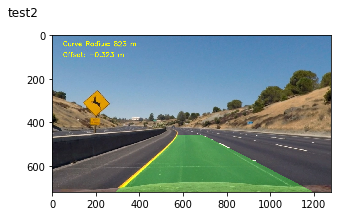

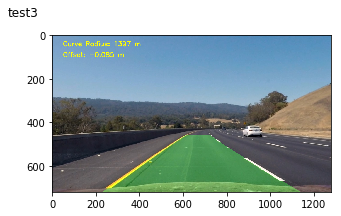

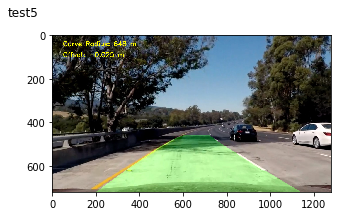

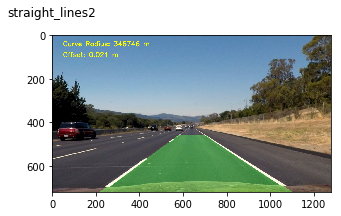

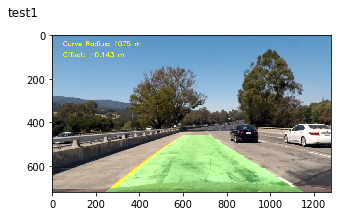

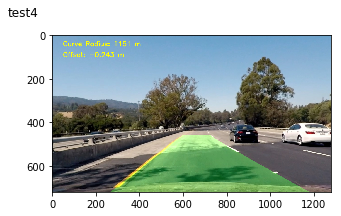

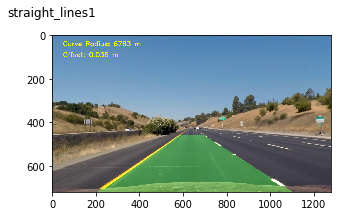

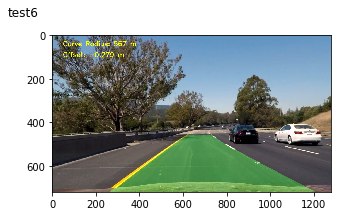

In [4]:
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    # Reinitialize previous fits so we start from the start since these images don't follow each other
    left_fit, right_fit = None, None
    img = pipeline(mpimg.imread(fname), debug=True)
    fname = fname[fname.rindex('/')+1:].replace('.jpg', '', 1)
    plt.figure(figsize=(5,5))
    plt.suptitle(fname, x = 0, y = 0.8, horizontalalignment = 'left')
    _ = plt.imshow(img[7])
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-undistorted.jpg', img[0], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-sxbinary.jpg', img[1], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-sybinary.jpg', img[2], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-s_binary.jpg', img[3], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-comb_binary.jpg', img[4], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-warped.jpg', img[5], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-warped_with_windows.jpg', img[6], format='jpg')
    _ = mpimg.imsave('output_images/' + fname + '_pipeline-fully-processed.jpg', img[7], format='jpg')

## Process Video

This section processes the input video frame-by-frame and outputs it. The pipeline is called without `debug=True` so that only the resulting image is returned.

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Re-initialize previous fits to make sure we aren't starting from the last run's stopping point
left_fit, right_fit = None, None

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(pipeline)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:17<00:00,  6.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 9s, sys: 3.04 s, total: 4min 12s
Wall time: 3min 18s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))